# Filling in the gaps in time series 

In [140]:
import numpy as np
import pandas as pd
from scipy import interpolate

import matplotlib.pyplot as plt

from pylab import rcParams
rcParams['figure.figsize'] = 15, 6

import warnings
warnings.filterwarnings('ignore')

In [34]:
# Load time series with gaps
ts_gaps = pd.read_csv('./ts_gaps.csv', sep = ',', index_col='Date', parse_dates=True)

# Load source time series
ts_real = pd.read_csv('./ts_real.csv', sep = ',', index_col='Date', parse_dates=True)

## Visualization

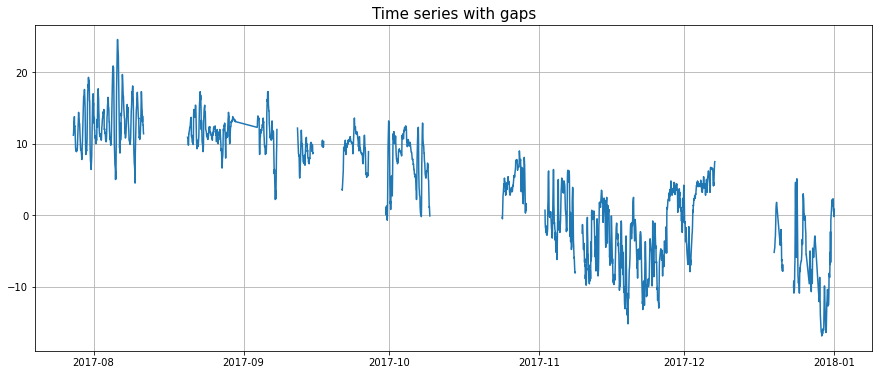

In [35]:
plt.plot(ts_gaps['T'])
plt.title('Time series with gaps', fontsize = 15)
plt.grid()
plt.show()

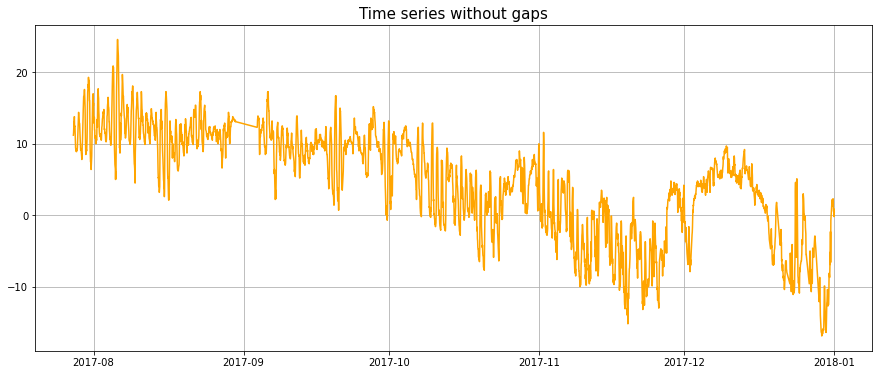

In [36]:
plt.plot(ts_real['T'], c = 'orange')
plt.title('Time series without gaps', fontsize = 15)
plt.grid()
plt.show()

## pandas in-box methods

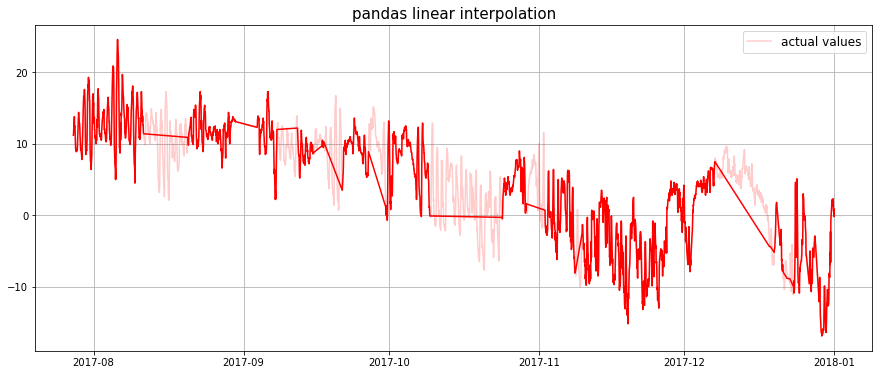

In [170]:
# Linear interpolation
df_new = ts_gaps.copy()
df_new['T'] = ts_gaps[['T']].interpolate(method='linear')['T']

plt.plot(df_new['T'], c = 'red')
plt.plot(ts_real['T'], c = 'red', alpha = 0.2, label = 'actual values')
plt.title('pandas linear interpolation', fontsize = 15)
plt.grid()
plt.legend(fontsize = 12)
plt.show()

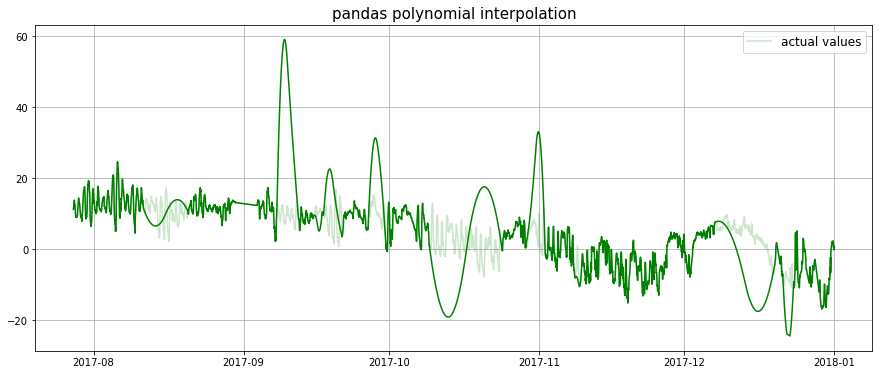

In [172]:
# Polynomial interpolation
df_new = ts_gaps.copy()
df_new['T'] = ts_gaps[['T']].interpolate(method='polynomial', order=2)['T']

plt.plot(df_new['T'], c = 'green')
plt.plot(ts_real['T'], c = 'green', alpha = 0.2, label = 'actual values')
plt.title('pandas polynomial interpolation', fontsize = 15)
plt.grid()
plt.legend(fontsize = 12)
plt.show()

## Self-made functions 

In this case, our solution is more flexible

In [107]:
def batch_pol_approximation(data: np.array, n_neighbors: int = 10, degree: int = 4, gap_value: float = -100.0):
    """Gapfilling function based on batch polynomial approximation

    Parameters
    ----------
    data : numpy array
        One-dimensional array (time series) in which we want to fill in the gaps
    n_neighbors : int
        The number of known elements adjacent to the gap that are used to evaluate the coefficients of the polynomial
    degree : int
        Degree of the polynomial function
    gap_value : float
        Gap flag in array

    Returns
    -------
    numpy array
        Time series without gaps

    """

    # Gap indices
    gap_list = np.ravel(np.argwhere(data == gap_value))
    new_gap_list = []
    local_gaps = []
    for index, gap in enumerate(gap_list):
        if index == 0:
            local_gaps.append(gap)
        else:
            prev_gap = gap_list[index - 1]
            if gap - prev_gap > 1:
                # There is a "gap" between gaps
                local_gaps.append(gap)
                new_gap_list.append(local_gaps)
                local_gaps = []
            else:
                local_gaps.append(gap)
    new_gap_list.append(local_gaps)

    # Iterately fill in the gaps in the time series
    for gap in new_gap_list:
        # Find the center point of the gap
        center_index = int((gap[0] + gap[-1])/2)

        # Indexes of known elements (updated at each iteration)
        i_known = np.argwhere(data != gap_value)
        i_known = np.ravel(i_known)

        # Based on the indexes we calculate how far from the gap the known values are located
        id_distances = np.abs(i_known - center_index)

        # Now we know the indices of the smallest values in the array, so sort indexes
        sorted_idx = np.argsort(id_distances)

        # Nearest known values to the gap
        nearest_values = []
        # And their indexes
        nearest_indices = []
        for i in sorted_idx[:n_neighbors]:
            # Getting the index value for the series - data
            time_index = i_known[i]
            # Using this index, we get the value of each of the "neighbors"
            nearest_values.append(data[time_index])
            nearest_indices.append(time_index)
        nearest_values = np.array(nearest_values)
        nearest_indices = np.array(nearest_indices)

        # Local approximation by an n-th degree polynomial
        local_coefs = np.polyfit(nearest_indices, nearest_values, degree)

        # Estimate our interval according to the selected coefficients
        est_value = np.polyval(local_coefs, gap)
        data[gap] = est_value

    return(data)

An illustration of the algorithm (approximation by 5 known neighboring points, the degree of the polynomial function - 3)

![batch_approximation.gif](https://raw.githubusercontent.com/Dreamlone/ITMO_materials/master/images/batch_approximation.gif) 

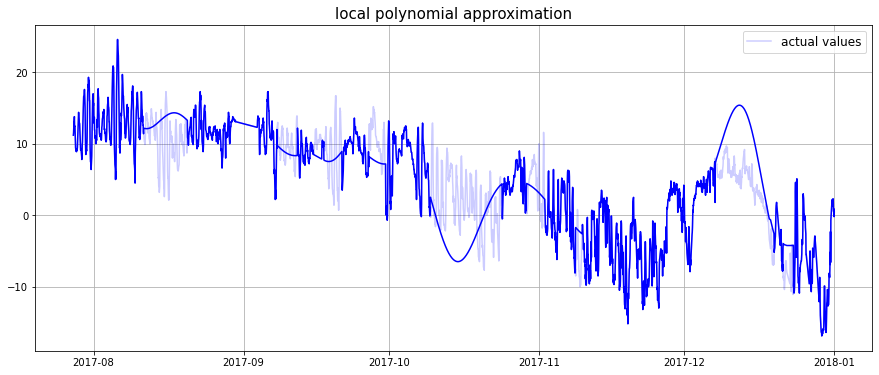

In [173]:
df_new = ts_gaps.copy()
arr_with_gaps = np.array(df_new['T'])

# Mask gaps with -100.0 value
arr_with_gaps[np.isnan(arr_with_gaps) == True] = -100.0
df_new['T'] = batch_pol_approximation(arr_with_gaps, n_neighbors = 900, degree = 15, gap_value = -100.0)

plt.plot(df_new['T'], c = 'blue')
plt.plot(ts_real['T'], c = 'blue', alpha = 0.2, label = 'actual values')
plt.title('local polynomial approximation', fontsize = 15)
plt.grid()
plt.legend(fontsize = 12)
plt.show()

Let's change the functionality a little

Now, the algorithm will work as follows
![Iterative_approximation.gif](https://raw.githubusercontent.com/Dreamlone/ITMO_materials/master/images/Iterative_approximation.gif) 

In [164]:
def pol_approximation(data: np.array, n_neighbors: int = 10, degree: int = 4, gap_value: float = -100.0):
    """Gapfilling function based on iterative polynomial approximation

    Parameters
    ----------
    data : numpy array
        One-dimensional array (time series) in which we want to fill in the gaps
    n_neighbors : int
        The number of known elements adjacent to the gap that are used to evaluate the coefficients of the polynomial
    degree : int
        Degree of the polynomial function
    gap_value : float
        Gap flag in array

    Returns
    -------
    numpy array
        Time series without gaps

    """
    
    i_gaps = np.argwhere(data == gap_value)
    i_gaps = np.ravel(i_gaps)

    for gap_index in i_gaps:
        i_known = np.argwhere(data != gap_value)
        i_known = np.ravel(i_known)

        id_distances = np.abs(i_known - gap_index)

        sorted_idx = np.argsort(id_distances)
        nearest_values = []
        nearest_indices = []
        for i in sorted_idx[:n_neighbors]:
            time_index = i_known[i]
            nearest_values.append(data[time_index])
            nearest_indices.append(time_index)
        nearest_values = np.array(nearest_values)
        nearest_indices = np.array(nearest_indices)
        
        local_coefs = np.polyfit(nearest_indices, nearest_values, degree)
        est_value = np.polyval(local_coefs, gap_index)
        data[gap_index] = est_value
        
    return(data)

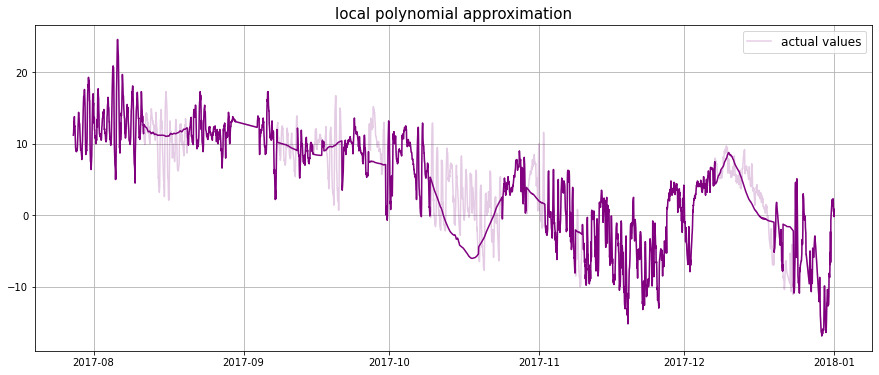

In [174]:
df_new = ts_gaps.copy()
arr_with_gaps = np.array(df_new['T'])

# Mask gaps with -100.0 value
arr_with_gaps[np.isnan(arr_with_gaps) == True] = -100.0
df_new['T'] = pol_approximation(arr_with_gaps, n_neighbors = 450, degree = 5, gap_value = -100.0)

plt.plot(df_new['T'], c = 'purple')
plt.plot(ts_real['T'], c = 'purple', alpha = 0.2, label = 'actual values')
plt.title('local polynomial approximation', fontsize = 15)
plt.grid()
plt.legend(fontsize = 12)
plt.show()